In [1]:
from gerrychain import Graph

In [2]:
filepath = r'C:\Users\Keegan\Downloads\districting-data-2020-county_NE\NE_county.json'

G = Graph.from_json(filepath)

In [3]:
for node in G.nodes:
    name = G.nodes[node]["NAME20"]
    population = G.nodes[node]['POP100']
    
    #Get Lat and Long Coordinates
    lat_coordinate = G.nodes[node]['INTPTLAT20']
    long_coordinate = G.nodes[node]['INTPTLON20']
    print("Node",node,'is',name,'County, with population',population,'and is centered at(',lat_coordinate,',',long_coordinate)
    
    

Node 0 is Sioux County, with population 1135 and is centered at( +42.4706681 , -103.7321705
Node 1 is Lincoln County, with population 34676 and is centered at( +41.0503221 , -100.7444808
Node 2 is Sherman County, with population 2959 and is centered at( +41.2187425 , -098.9728492
Node 3 is Logan County, with population 716 and is centered at( +41.5421555 , -100.4436647
Node 4 is Merrick County, with population 7668 and is centered at( +41.1697896 , -098.0310573
Node 5 is Sheridan County, with population 5127 and is centered at( +42.5122888 , -102.3682795
Node 6 is Pawnee County, with population 2544 and is centered at( +40.1377971 , -096.2452136
Node 7 is Sarpy County, with population 190604 and is centered at( +41.1150635 , -096.1091254
Node 8 is Grant County, with population 611 and is centered at( +41.9139574 , -101.7559645
Node 9 is Burt County, with population 6722 and is centered at( +41.8541794 , -096.3377462
Node 10 is Saunders County, with population 22278 and is centered at( 

In [4]:
pip install geopy --user

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [6]:
from geopy.distance import geodesic

In [35]:
# create distance dictionary
dist = dict()
for i in G.nodes:
    for j in G.nodes:
        location_i= (G.nodes[i]['INTPTLAT20'],G.nodes[i]['INTPTLON20'])
        location_j=(G.nodes[j]['INTPTLAT20'],G.nodes[j]['INTPTLON20'])
        dist[i,j] =geodesic(location_i,location_j).miles

In [36]:
#check dictionary
print("Gosper -> Gage",dist[86,87])

Gosper -> Gage 166.5811815392005


In [37]:
# Let's impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 3          # number of districts
total_population = sum(G.nodes[node]['POP100'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)


Using L = 650566 and U = 657103 and k = 3


In [38]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, G.nodes, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j


In [39]:
# objective is to minimize the moment of inertia: d^2 * p * x
m.setObjective( gp.quicksum( dist[i,j]*dist[i,j]*G.nodes[i]['POP100']*x[i,j] for i in G.nodes for j in G.nodes), GRB.MINIMIZE)

In [40]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in G.nodes) == 1 for i in G.nodes)

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['POP100'] * x[i,j] for i in G.nodes) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['POP100'] * x[i,j] for i in G.nodes) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [41]:
m.Params.MIPGap = 0.0
m.optimize()

Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 8929 rows, 8649 columns and 43152 nonzeros
Model fingerprint: 0xe98f3ee6
Variable types: 0 continuous, 8649 integer (8649 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [1e+05, 9e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 190 rows and 4 columns
Presolve time: 0.08s
Presolved: 8739 rows, 8645 columns, 43221 nonzeros
Variable types: 0 continuous, 8645 integer (8645 binary)
Found heuristic solution: objective 6.734167e+10
Found heuristic solution: objective 3.618021e+10

Root relaxation: objective 8.899077e+09, 4281 iterations, 0.61 seconds

    Nodes    

In [46]:
print('moment of intertia objective is,',m.objval)
#retrieve the districs and the populations
# retrieve the districts and their populations
centers = [j for j in G.nodes if x[j,j].x >0.5]
districts1 = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in centers]
district_counties1 = [ [ G.nodes[i]["NAME20"] for i in districts1[j] ] for j in range(k)]
district_populations1 = [ sum(G.nodes[i]["POP100"] for i in districts1[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations1[j],"and contains counties",district_counties1[j])

moment of intertia objective is, 8958454703.65208
District 0 has population 652373 and contains counties ['Sioux', 'Lincoln', 'Sherman', 'Logan', 'Merrick', 'Sheridan', 'Grant', 'Blaine', 'Dixon', 'Stanton', 'Wheeler', 'Franklin', 'Chase', 'Buffalo', 'Fillmore', 'York', 'Seward', 'Clay', 'Cheyenne', 'Garden', 'Harlan', 'Hooker', 'Furnas', 'Howard', 'Valley', 'Cedar', 'Thayer', 'Deuel', 'Morrill', 'Hall', 'Hamilton', 'Loup', 'Frontier', 'Nance', 'Knox', 'Perkins', 'Colfax', 'Butler', 'Cherry', 'Nuckolls', 'Keith', 'Phelps', 'Webster', 'Boyd', 'Thomas', 'Holt', 'Brown', 'Keya Paha', 'Banner', 'Greeley', 'Jefferson', 'Saline', 'Dundy', 'Scotts Bluff', 'Adams', 'Kearney', 'Hitchcock', 'Kimball', 'Custer', 'Polk', 'Dawes', 'Wayne', 'Garfield', 'Pierce', 'Platte', 'Box Butte', 'Boone', 'Madison', 'McPherson', 'Red Willow', 'Rock', 'Gosper', 'Dawson', 'Arthur', 'Hayes', 'Antelope']
District 1 has population 652576 and contains counties ['Pawnee', 'Sarpy', 'Saunders', 'Dodge', 'Richardson', 'L

In [47]:
# Draw it on a map
import geopandas as gpd

In [48]:
# Read shapefile from"NE_county.shp"
filename1 = r"C:\Users\Keegan\Downloads\districting-data-2020-county_NE\NE_county.shp"

# Read geopandas dataframe from the file

df = gpd.read_file(filename1)

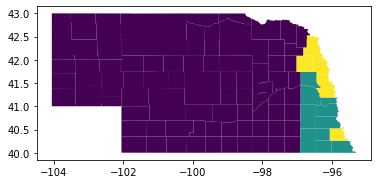

In [49]:
# Which district is each county assigned to?
assignment1 = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts1)):
    
    # for each node i in this district
    for i in districts1[j]:
        
        # What is its GEOID?
        geoID1 = G.nodes[i]["GEOID20"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID1 == df['GEOID20'][u]: # Found it
                assignment1[u] = j 
                
# Now add the assignments to a column of the dataframe and map it
df2['assignment1'] = assignment1
fig1 = df2.plot(column='assignment1').get_figure()
